# What Happened to Code Violations in Seattle?

This is part 1 of a project I initially started as a way of helping me find a new apartment around Seattle. As a recent-grad, I wanted to find a place around U-District to keep me close to the University + Downtown for potential work. U-District is not a pretty place, but go 20 minutes away from campus in any direction and things look much better. By looking at code violations around the city I would get some insight into the quality of local neighborhoods. Combining this with criminal activity throughout Seattle would give me an even better idea of what I was getting myself into.

But why stop there? The data is already there (and surprisingly well taken!), so I expanded the scope of the project a bit. Right now, part 1 is a way of:
<ol>
    <li>Getting an inkling of the quality of each neighborhood</li>
    <li>Learning more about using the Pandas Python package</li> 
    <li>Figuring out why the number of code violation cases drastically dropped in 2010</li> 
</ol>

I roughly followed along with a [blog post](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) by data scientist Jake Vanderplas at the University of Washington eScience Institute. He does a very thorough analysis of timeseries data of cyclists in Seattle instead, I highly recommend reading his blog to learn more about data science and Python techniques.

## The Data

I use three datasets in part 1. One contains [code violations](https://data.seattle.gov/Community/Code-Violation-Cases/dk8m-pdjf) in the Seattle neighborhoods going back ~15 years. There are 33918 individual code violation cases of various types in this dataset. It includes the type, description, address, geographical location, and various dates of the recorded violation. Many of the earliest cases are missing bits of data such as the date the case was created by the city.
The other two datasets contain building permits ([here](https://data.seattle.gov/Permitting/Building-Permits-Current/mags-97de) and [here](https://data.seattle.gov/Permitting/Building-Permits-Older-than-5-years/47eb-r92t)) applied for and issued by the city for various projects in the past ~10 years. There are 81840 permit applications in this dataset. Many are still ongoing projects. They include the type, address, geographical location, and various dates of permit issuing/expiration.

## The Analysis

### Creation vs Inspection

I'll start by importing Pandas, Matplotlib, and Numpy to read in the datasets, then plot & perform operations with it. The data come as CSV files, and Pandas has fabulous features for reading in and parsing properly-formatted CSV files. I will be using the date on which the violation cases were created as the index for timeseries' that I create. This makes later manipulation easier, and makes it easier to keep track of various cases.

In [164]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') #Matplotlib 'ggplot' style sheet for all subsequent plots

violations = pd.read_csv('violations.csv', header=0, index_col='Date Case Created')
violations.index = pd.DatetimeIndex(violations.index) #Convert the date index to a DatetimeIndex object

I can make a histogram of the different code violation cases submitted to the city. These are complaints that were acknowledged by the city and may or may not have had subsequent followup on.

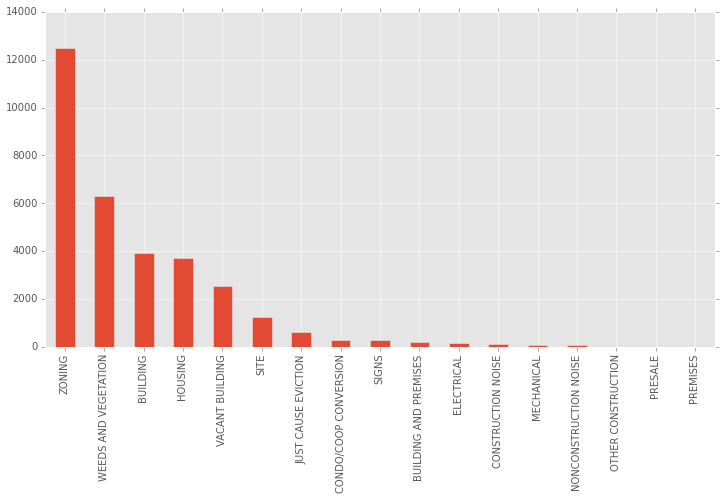

In [168]:
violations['Case Group'].value_counts().plot(kind='bar', figsize=(12,6))

The overwhelming majority are 'ZONING' violations, followed not-to-closely by 'WEEDS AND VEGETATION' violations. Together, these make up over 50% of all cases.

In [169]:
violations['Case Group'].value_counts()

ZONING                   12480
WEEDS AND VEGETATION      6291
BUILDING                  3905
HOUSING                   3700
VACANT BUILDING           2522
SITE                      1265
JUST CAUSE EVICTION        608
CONDO/COOP CONVERSION      305
SIGNS                      302
BUILDING AND PREMISES      212
ELECTRICAL                 176
CONSTRUCTION NOISE         108
MECHANICAL                  92
NONCONSTRUCTION NOISE       55
OTHER CONSTRUCTION          11
PRESALE                      8
PREMISES                     4
dtype: int64

At a glance, it looks like the majority of these violations are from people complaining about their neighbors! Interestingly enough, despite there being constant construction everywhere, there aren't that many complaints about construction related issues. It may be that construction related violations are handled by another government entity.

Each entry of the data includes the type of violation, the location at which the violation took place, the date on which the city opened a case, and outcomes of followup inspections. Though I'll ultimately be using the dates on which cases were created, it's at least interesting to see a little about how inspections are handled by the city as well.

A good way to visualize this data is to setup a timeseries of it, which Pandas is perfect for. At a first glance, the dates on which cases are created aren't regular, and neither are the dates where agents followup on those cases. By counting up all of the cases created/inspected on a given day, I can create a timeseries over the 10 years. Pandas dataframes offer a very convenient way of compiling the two timeseries.

In [4]:
case_counts = violations.index.value_counts()
inspec_counts = violations['Last Inspection Date'].value_counts()

case_dates = pd.to_datetime(case_counts.index, format='%m/%d/%Y')
inspec_dates = pd.to_datetime(inspec_counts.index, format='%m/%d/%Y')

inspections = pd.DataFrame({'Case Creation': pd.Series(case_counts.tolist(), index=case_dates),
                           'Followup Inspection': pd.Series(inspec_counts.tolist(), index=inspec_dates)})
inspections.tail(5)

,Case Creation,Followup Inspection
2015-08-04,15,18
2015-08-05,8,4
2015-08-06,11,13
2015-08-23,NaN,1
2015-12-05,NaN,1


Notice that there are NaNs all throughout where there are either no case creations or followup inspections on that day. I can fix this with a simple replacement of NaNs with 0.

In [170]:
inspections = inspections.fillna(0)

And now the pretty part. Since plotting day by day is messy, I can use Pandas to resample up to monthly and annual cadences.

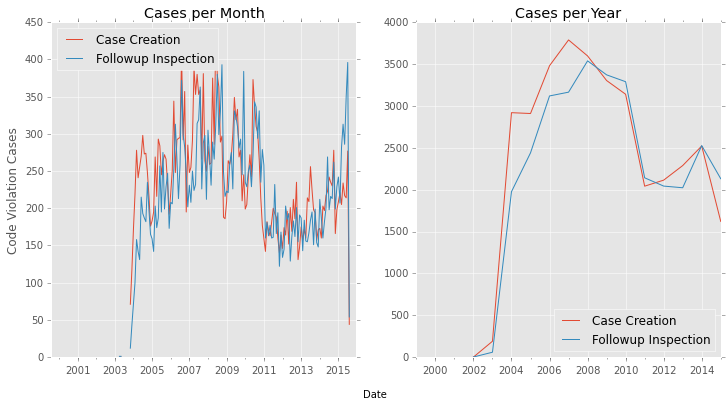

In [172]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].set_ylabel('Code Violation Cases')
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
inspections[['Case Creation','Followup Inspection']].resample('M',how='sum').plot(ax=axes[0]).set_title('Cases per Month')
inspections[['Case Creation','Followup Inspection']].resample('A',how='sum').plot(ax=axes[1]).set_title('Cases per Year')

Curiously enough, there are significantly more cases created than are followup inspected by the city. This could be due to a number of things, such as certain cases not requiring in-person followup.
However most surprising is the huge drop in cases (>1000 cases), both followed-up and not followed-up, around 2010. That's a pretty blatant anomaly and most likely has some kind of external cause. In fact we can look at the average number of cases per day before and after the drop in 2010.

In [176]:
print('Pre-2010: '+str(inspections['Case Creation'][:'2010-01-01'].mean()))
print('Post-2010: '+str(inspections['Case Creation']['2010-01-01':].mean()))

Pre-2010: 12.192632850241546
Post-2010: 9.453856749311294


Weird, right? Before I get any further into this drop, I am going to try to look at the smaller details first. If I'm going to properly use this data, I want to take out as many anomalies as possible to have data that is equally relevant across the entire set.
After thinking about it a little, the most obvious sources of small biases are likely to be seasonal variations (who wants to go investigate a case in the dead of winter?) and day of the week (cases might be entered on very specific days). Luckily, Jake Vanderplas has a nifty function for finding seasonal variations, which I will use shortly.

I can set up a season dictionary for the months to figure out the season for every day on which at least one case appears, as well as for each case itself. This gives a rough initial picture on what kinds of variations there may be during the year in how often cases are investigated, and in how many cases are acknowledged.

In [178]:
SEASON = {1:'Winter', 2:'Winter', 3:'Winter', 4:'Spring', 5:'Spring', 6:'Spring', 
          7:'Summer', 8:'Summer', 9:'Summer', 10:'Autumn', 11:'Autumn', 12:'Winter'}

inspections['Case Season'] = pd.Series([SEASON[i] for i in inspections.index.month], index=inspections.index)
violations['Case Season'] = pd.Series([SEASON[i] for i in violations.index.month],
                                      index=violations.index)

Just to make it easier for the next plot, I'll make a couple temporary data frames. A cleaner method for what I want through Pandas wasn't readily obvious.

In [225]:
df1 = pd.DataFrame({'Pre-2010': violations['Case Season']['2010-01-01':].value_counts(),
                    'Post-2010': violations['Case Season'][:'2010-01-01'].value_counts()})
df2 = pd.DataFrame({'Pre-2010': inspections['Case Season']['2010-01-01':].value_counts(),
                    'Post-2010': inspections['Case Season'][:'2010-01-01'].value_counts()}) 

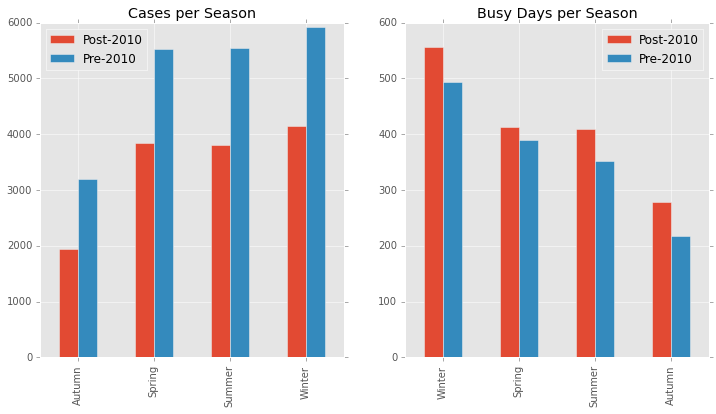

In [224]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

df1.plot(kind='bar', ax=axes[0], legend=True)
df2.plot(kind='bar', ax=axes[1], legend=True)

axes[1].set_title('Busy Days per Season')
axes[0].set_title('Cases per Season')

First, winter has a small lead in the sheer number of cases created per season, but it has a pretty sizable lead on the number of days the city takes to perform an initial followup on the cases. In other words, complaints are just as likely to happen in winter, summer, and spring. Additionally, autumnal cases are much less common and there are fewer days where inspections happen. This can serve as an indicator that there is seasonal variation that can be subtracted out.

Furthermore I can check to see if there is variation on a day-to-day basis in a similar way.

In [9]:
WEEKDAY = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 
            4:'Fri', 5:'Sat', 6:'Sun'}

inspections['Case Day'] = pd.Series([WEEKDAY[i] for i in inspections.index.weekday], index=inspections.index)
violations['Case Day'] = pd.Series([WEEKDAY[i] for i in pd.DatetimeIndex(violations.index).weekday],
                                  index = violations.index)

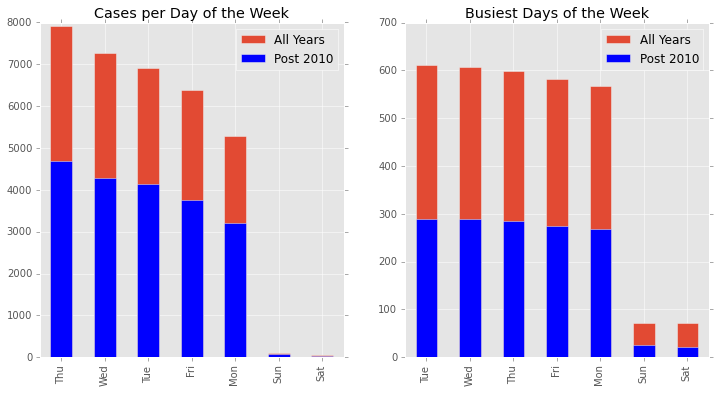

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

violations['Case Day'].value_counts().plot(kind='bar', ax=axes[0],
                                          label='All Years', legend=True)
violations['Case Day']['2010-01-01':].value_counts().plot(kind='bar', ax=axes[0],
                                                color='b', label='Post 2010', legend=True)
inspections['Case Day'].value_counts().plot(kind='bar', ax=axes[1],
                                         label='All Years', legend=True)
inspections['Case Day']['2010-01-01':].value_counts().plot(kind='bar', ax=axes[1],
                                               color='b', label='Post 2010', legend=True)
axes[1].set_title('Busiest Days of the Week')
axes[0].set_title('Cases per Day of the Week')

Seasonal and daily patterns still hold after 2010. Cases generally aren't investigated on the weekend, and Thursday is the most popular day for cases to be officially created. Cases are investigated roughly equally across all weekdays.

Now for the fun part! I lifted a function from Jake Vanderplas to calculate the daylight hours in Seattle throughout the year. This allows me to find the number of hours of daylight for each individual inspection, so that I can subtract out seasonal variations. I can also simultaneosly subtract out the daily variations.

In [11]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

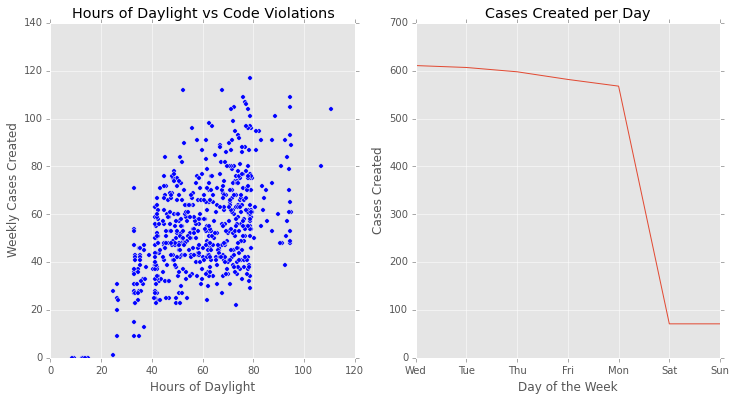

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

inspections['Hours Daylight'] = inspections.index.map(hours_of_daylight)
axes[0].scatter(x=inspections['Hours Daylight'].resample('W', how='sum'),
                y=inspections['Case Creation'].resample('W', how='sum'))
axes[0].set_xlabel('Hours of Daylight') ; axes[0].set_ylabel('Weekly Cases Created')
axes[0].set_ylim(0,)
axes[0].set_title('Hours of Daylight vs Code Violations')

inspections['Case Day'].value_counts().plot(ax=axes[1])
axes[1].set_ylabel('Cases Created') ; axes[1].set_xlabel('Day of the Week')
axes[1].set_title('Cases Created per Day')

sklearn is one of few up-to-date packages that properly handles multivariate regression. I can use this to fit both the seasonal and daily variations at once. First I create a new column for the weekday number instead of name (e.g, 0 instead of 'Monday').

In [13]:
inspections['Case Day Number'] = pd.Series(inspections.index.dayofweek, index=inspections.index)

Then I can fit with sklearn

In [14]:
from sklearn.linear_model import LinearRegression

fit = LinearRegression().fit(inspections[['Hours Daylight','Case Day Number']], inspections['Case Creation'])

Then de-trend and plot in monthly cadence for some clarity:

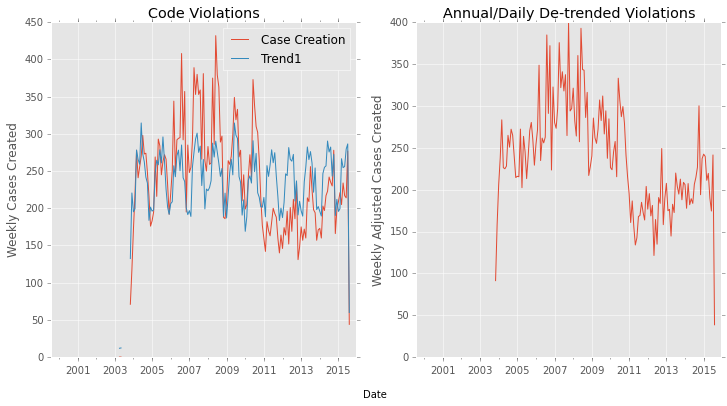

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

inspections['Trend1'] = fit.predict(inspections[['Hours Daylight','Case Day Number']])
inspections[['Case Creation','Trend1']].resample('M', how='sum').plot(ax=axes[0], title='Code Violations')

inspections['DeTrended1'] = inspections['Case Creation'] - inspections['Trend1'] + inspections['Trend1'].mean()
inspections['DeTrended1'].resample('M',how='sum').plot(ax=axes[1], title='Annual/Daily De-trended Violations')

axes[0].set_ylabel('Weekly Cases Created')
axes[1].set_ylabel('Weekly Adjusted Cases Created')
axes[1].set_ylim(0,)
fig.text(0.5, 0.04, 'Date', ha='center', va='center')

Not a huge difference, but the counts are noticeably lower. The right plot shows how cases would be accepted by the city if there were no seasonal or daily variations. There's pretty clearly other forces at play here so I decided to do some Internet sleuthing! I found a memo from the Seattle Department of Planning & Development regarding, among other things, the volume of violation complaints for a few years prior.

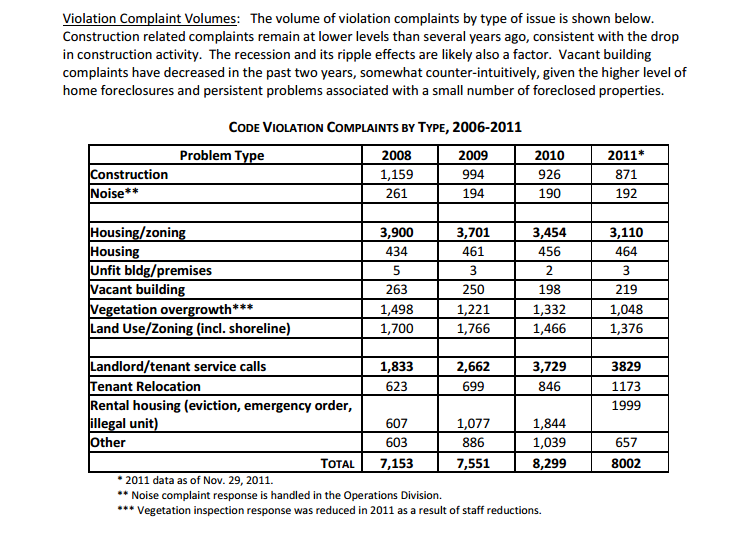

In [16]:
from IPython.display import Image
Image(filename='violations.png')

From the looks of it, there are a few factors. Construction complaints dropped a bit, and housing/zoning complaints began to drop off quickly due to vegetation overgrowth inspections being reduced and fewer land use complaints.

Fortunately, the original data allows one to sort by the type of code violation case!

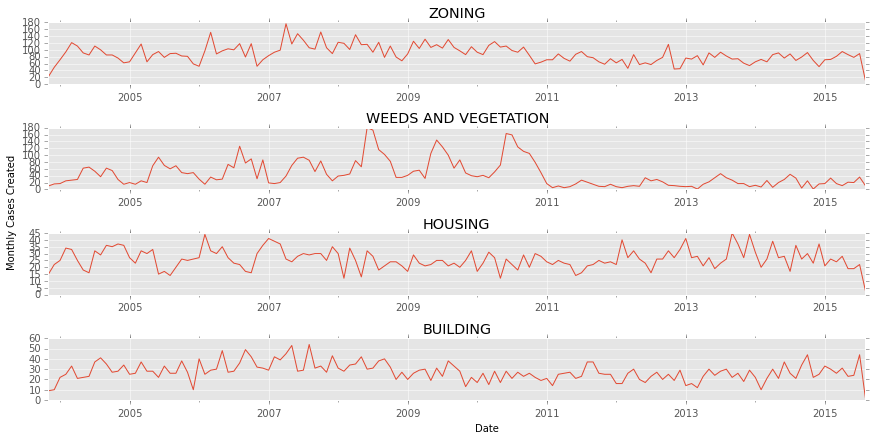

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,6))

complaints = ['ZONING', 'WEEDS AND VEGETATION', 'HOUSING', 'BUILDING']
for i in range(len(complaints)):
    violations[violations['Case Group'] == complaints[i]].index.value_counts(
                    ).resample('M',how='sum').plot(ax=axes[i], title=complaints[i])
fig.text(0.0, 0.5, 'Monthly Cases Created', ha='center', va='center', rotation='vertical')
fig.text(0.55, 0.0, 'Date', ha='center', va='center')
plt.tight_layout()

I can readily find the average of the important components and de-trend the rest of the data. If I were doing more important things with this data, I would probably stop before averaging out these violations -- I'm effectively throwing out bits of information. But the end goal is to find a nice place to live, so the question becomes which one is the most important?

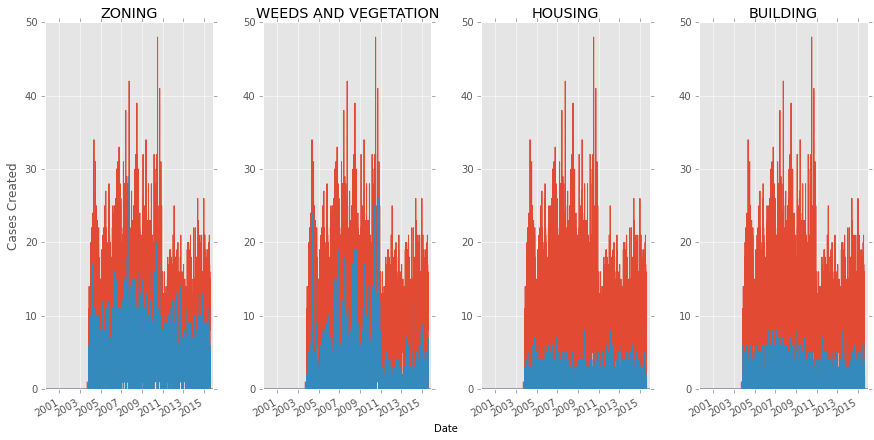

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,6))

for i in range(len(complaints)):
    inspections[complaints[i]] = violations[violations['Case Group'] == complaints[i]].index.value_counts()
    inspections[complaints[i]] = inspections[complaints[i]].fillna(0) 
    inspections['Case Creation'].plot(ax=axes[i])
    inspections[complaints[i]].plot(ax=axes[i], title=complaints[i])
    
plt.tight_layout()
axes[0].set_ylabel('Cases Created')
fig.text(0.5, 0.0, 'Date', ha='center', va='center')

The biggest contributors to the drop are zoning and weeds/vegetation, so I can ignore the other two.

In [146]:
complaints = ['ZONING', 'WEEDS AND VEGETATION']
inspections['Trend2'] = inspections[complaints[0]].add(inspections[complaints[1]], fill_value=0)

And now the plotting:

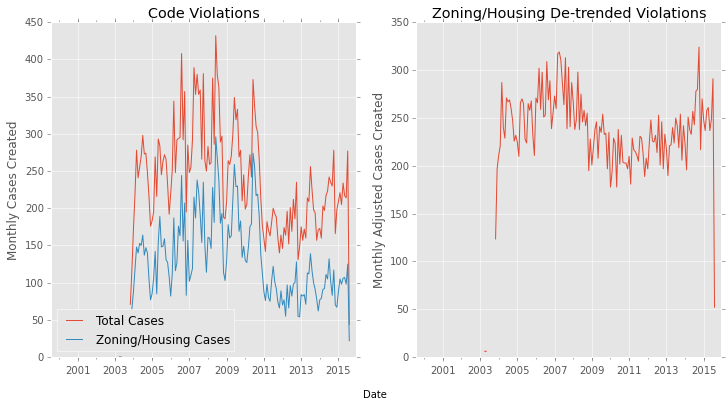

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

inspections['Case Creation'].resample('M', how='sum').plot(ax=axes[0], label='Total Cases', legend=True)
inspections['Trend2'].resample('M', how='sum').plot(ax=axes[0], title='Code Violations',
                                                    label='Zoning/Housing Cases', legend=True)
inspections['DeTrended2'] = (inspections['Case Creation'] - inspections['Trend2'] + inspections['Trend2'].mean())
inspections['DeTrended2'].resample('M', how='sum').plot(ax=axes[1], title='Zoning/Housing De-trended Violations')

axes[0].set_ylabel('Monthly Cases Created')
axes[1].set_ylabel('Monthly Adjusted Cases Created')
fig.text(0.5, 0.04, 'Date', ha='center', va='center')

Looking much better! But there is another piece of the puzzle that wasn't taken into account in this: construction violations. They don't make up as big of a chunk, but I like to cover my bases. For this, I picked up another couple datasets regarding permitting by the city. These are permits for any sort of construction activity. The first is for permits in the past 5 years, and the second is for permits older than 5 years stretching back to about 10 years ago.

In [148]:
construction1 = pd.read_csv('construction.csv', header=0, index_col='Issue Date')
construction2 = pd.read_csv('construction2.csv', header=0, index_col='Issue Date')
construction = pd.concat([construction1,construction2])

The headers include location, date of application, date of issuing, final projected date, and expiration date. The most relevant one is probably how many permits the city itself acknowledges and gives out, so I make a timeseries for the permit issuing dates.

In [149]:
issue_counts = construction.index.value_counts()
issue_dates = pd.to_datetime(issue_counts.index, format='%m/%d/%Y')

inspections['Issue Permit'] = pd.Series(issue_counts.tolist(), index=issue_dates)
inspections['Issue Permit'] = inspections['Issue Permit'].fillna(0)

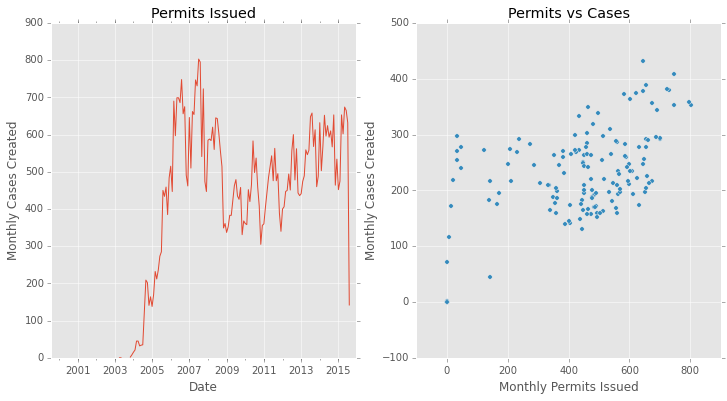

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

inspections['Issue Permit'].resample('M', how='sum').plot(ax=axes[0], title='Permits Issued')
inspections.resample('M', how='sum').plot(kind='scatter', ax=axes[1], x='Issue Permit',
                                          y='Case Creation', title='Permits vs Cases')

axes[0].set_ylabel('Monthly Cases Created')
axes[0].set_xlabel('Date')
axes[1].set_ylabel('Monthly Cases Created')
axes[1].set_xlabel('Monthly Permits Issued')

Using sklearn again, I can take out biases induced by reduced construction activity. By the looks of the plot, I can set a minimum cutoff date for permit issuing around the start of 2003. There were no violation cases created before that time anyway. Using sklearn's wonderful multivariate regression capabilities, I can take into account seasonal and daily variations as well as construction permitting and violation reason all at once. I do this after resampling to monthly cadence since this scales everything to larger, more meaningful numbers.

In [151]:
headers = complaints + ['Hours Daylight', 'Case Day Number', 'Issue Permit']
monthly = inspections.resample('M', how='sum').dropna()

fit = LinearRegression().fit(monthly[headers], monthly['Case Creation'])

And here's the de-trended code violation plot:

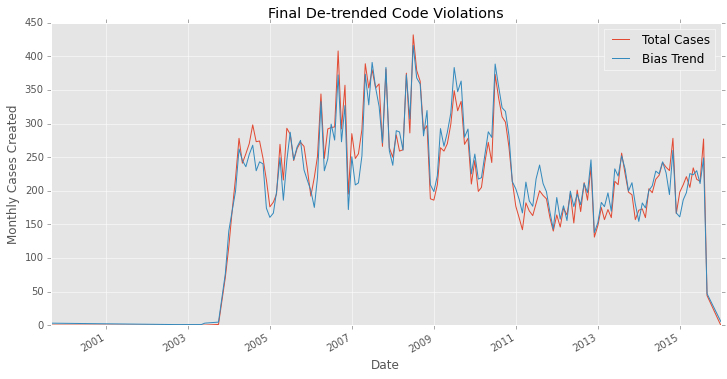

In [152]:
monthly['Trend3'] = fit.predict(monthly[headers])
monthly['DeTrended3'] = monthly['Case Creation'] - monthly['Trend3'] + monthly['Trend3'].mean()

monthly['Case Creation'].plot(figsize=(12,6), label='Total Cases', legend=True)
monthly['Trend3'].plot(title='Final De-trended Code Violations',
                                                    label='Bias Trend', legend=True)

plt.ylabel('Monthly Cases Created') ; plt.xlabel('Date')

And the lovely de-trended data plot:

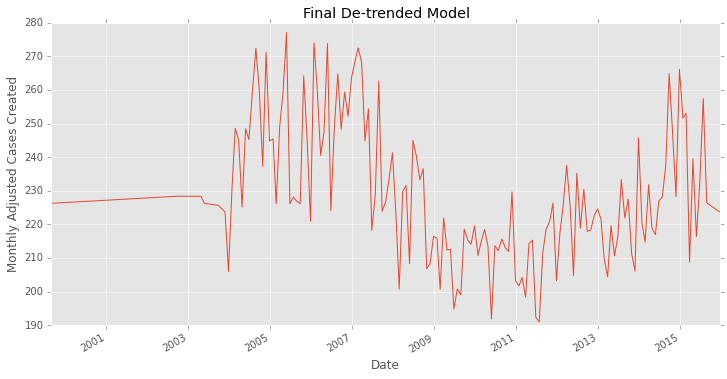

In [153]:
monthly['DeTrended3'].plot(title='Final De-trended Model', figsize=(12,6))
plt.ylabel('Monthly Adjusted Cases Created')
plt.xlabel('Date')

Now for error analysis. I calculate covariances using the methods in Vanderplas' blog post. The justification for this method can be found [here](http://www.unc.edu/~jjharden/methods/vcv_week3.pdf).

In [154]:
x_i = monthly[headers]
y = monthly['Case Creation']
model = monthly['Trend3']

var_y = np.sum(y.subtract(model,axis=0)** 2) / len(y)
X = np.hstack([x_i, np.ones((x_i.shape[0], 1))])
C = var_y * np.linalg.inv(np.dot(X.T, X))
var_tot = C.diagonal()

So now I have the slopes of each quantity in the multivariate regression, as well as their respective variances. I also have the RMS of the detrended and original monthly data.

In [155]:
for i in range(len(headers)):
    print(headers[i]+': '+str(fit.coef_[i])+' +/- '+str(np.sqrt(var_tot[i])))
    
print('Original RMS: ' + str(monthly['Case Creation'].std()))
print('De-Trended RMS: ' + str(monthly['DeTrended3'].std()))

ZONING: 1.32992694196 +/- 0.0854267351622
WEEDS AND VEGETATION: 0.899451791994 +/- 0.0526056224064
Hours Daylight: 0.0552149812288 +/- 0.0322259244378
Case Day Number: 1.00307023741 +/- 0.215986275943
Issue Permit: 0.0430742709651 +/- 0.0100900457402
Original RMS: 82.30668682931699
De-Trended RMS: 20.17645284926874


In [156]:
for i in range(len(headers)):
    print(headers[i]+' error: '+str(np.sqrt(var_tot[i])*100 / fit.coef_[i])+'%')

ZONING error: 6.42341563789%
WEEDS AND VEGETATION error: 5.84863167482%
Hours Daylight error: 58.3644578349%
Case Day Number error: 21.5325176532%
Issue Permit error: 23.4247626579%


It looks like including seasonal variations wasn't the best idea. The errors jump up a lot when taking those into account.